## Questão 2 - Prova 2 IA

2) Considere o mapa rodoviário simplificado envolvendo cidades de
Portugal, com localização de rotas, bem como o problema de dirigir de X
a Y. Assuma o uso da heurística de distância em linha reta. O objetivo é
chegar na cidade do Porto, saindo da cidade Castelo Branco. Mostre como
seriam possíveis execuções, com o passo a passo, para cada um dos 3
algoritmos mencionados na questão 1).

In [49]:
# Importação das bibliotecas usadas
from dataclasses import dataclass, field
import copy
import secrets
import heapq
from IPython.display import Image
import pygraphviz as pgv

### Definição da Estrutura do Problema

In [4]:
@dataclass
class Graph:

    n: int
    adj_list: dict[str, set[tuple[str, int]]] = field(init=False)

    def __post_init__(self):
        self.adj_list = {}

    def add_edge(self, u: str, v: str, w: int):
        if u not in self.adj_list.keys():
            self.adj_list[u] = set()
        if v not in self.adj_list.keys():
            self.adj_list[v] = set()
        self.adj_list[u].add((v, w))
        self.adj_list[v].add((u, w))

    def __repr__(self):
        edges = "\n".join(f"{u}: {e}" for u, e in self.adj_list.items())
        return edges

    def N(self, u: str):
        return self.adj_list[u]

In [42]:
# Montando o grafo
with open("graph.txt", "r") as f:
    n = f.readline().strip()
    graph = Graph(n)
    while True:
        edge = f.readline()
        if edge:
            u, v, w = edge.split()
            graph.add_edge(u, v, int(w))
        else:
            break

In [43]:
graph

porto: {('vila_real', 120), ('viana_castelo', 80), ('braga', 50), ('aveiro', 70)}
aveiro: {('coimbra', 80), ('viseu', 100), ('porto', 70)}
braga: {('vila_real', 100), ('viana_castelo', 50), ('porto', 50)}
vila_real: {('bragança', 140), ('guarda', 150), ('porto', 120), ('viseu', 110), ('braga', 100)}
viana_castelo: {('porto', 80), ('braga', 50)}
bragança: {('guarda', 200), ('vila_real', 140)}
guarda: {('bragança', 200), ('coimbra', 160), ('castelo_branco', 100), ('vila_real', 150), ('viseu', 80)}
viseu: {('coimbra', 80), ('aveiro', 100), ('vila_real', 110), ('guarda', 80)}
coimbra: {('castelo_branco', 160), ('leiria', 70), ('aveiro', 80), ('viseu', 80), ('guarda', 160)}
castelo_branco: {('coimbra', 160), ('guarda', 100), ('santarém', 200), ('portalegre', 150)}
leiria: {('coimbra', 70), ('lisboa', 130)}
santarém: {('évora', 120), ('castelo_branco', 200), ('lisboa', 70)}
portalegre: {('castelo_branco', 150), ('évora', 100)}
évora: {('portalegre', 100), ('lisboa', 150), ('santarém', 120), 

In [8]:
h = {}
with open("h.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        city, dist = line.split()
        h[city] = int(dist)

In [9]:
h

{'aveiro': 58,
 'beja': 356,
 'braga': 46,
 'bragança': 172,
 'castelo_branco': 177,
 'coimbra': 108,
 'évora': 294,
 'faro': 520,
 'guarda': 133,
 'leiria': 157,
 'lisboa': 274,
 'portalegre': 231,
 'porto': 0,
 'santarém': 214,
 'setúbal': 294,
 'viana_castelo': 62,
 'vila_real': 76,
 'viseu': 82}

In [115]:
def get_graphviz_node(node: str, h: dict, g: dict | None = None):
    label = node + "\n"
    label += f"h = {h[node]}" 
    label += f", g={g[node]}\n" if g else ""
    label += f"f = {h[node]+g[node]}" if g else ""
    return dict(
        n = secrets.token_hex(8),
        label = label,
        shape="ellipse",
        style="bold", 
        color="blue"
    )

#### Algoritmo Hill Climb

Tentativa com algoritmo *Hill Climb* (Subida de Encosta) para a solução problema do menor caminho entre as estradas de duas cidades, considerando a distância em linha reta dada como heurística

```bash
FUNC hill_climb(estado_inicial, estado_objetivo) -> estado_maximo_local
    estado_atual := estado_inicial
    ENQUANTO estado_atual != estado_objetivo:
        estado_vizinho := melhor_sucessor_de(estado_atual)
        SE h(estado_vizinho) >= h(estado_atual):
            RETORNA estado_atual
        estado_atual = estado_vizinho
```


In [13]:
def hill_climb(graph, start: str, goal: str):
    steps = 0
    path = [start]
    current = start
    while current != goal:
        steps += 1
        neighbors = [(v, h[v]) for v, w in graph.N(current)]
        best_neighbor, best_cost = sorted(neighbors, key = lambda x: x[1])[0]

        if best_cost >= h[current]:
            break

        current = best_neighbor
        path.append(current)

    print(f"Máximo local encontrado em {steps} passos!")
    return path


In [23]:
def get_hill_climb_path(path):
    """
    retorna grafo direcionado para o caminho encontrado com Hill Climb
    """
    g = pgv.AGraph(directed=True)
    last_state = path[0]
    g.graph_attr['rankdir'] = 'LR'
    pgv_params = get_graphviz_node(last_state, h)
    g.add_node(**pgv_params)
    for state in path[1:]:
        pgv_params = get_graphviz_node(state, h)
        g.add_node(**pgv_params)
        g.add_edge(hash(last_state), hash(state))
        last_state = state
    return g

In [14]:
path = hill_climb(graph, "castelo_branco", "porto")
print(path)

Máximo local encontrado em 3 passos!
['castelo_branco', 'coimbra', 'aveiro', 'porto']


In [31]:
g = get_hill_climb_path(path)
g.layout(prog='dot')
g.draw('src/q2_hill_climb.png')

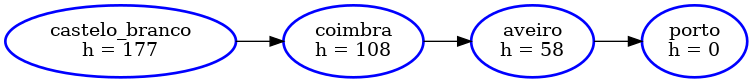

In [32]:
Image('src/q2_hill_climb.png')

#### Algoritmo Guloso

Tentativa com **Algoritmo Guloso** para a solução problema do menor caminho entre as estradas de duas cidades, considerando a distância em linha reta dada como heurística

```bash
FUNC greedy_algorithm(estado_inicial, estado_objetivo) -> solução
    visitados := [] # explorados
    fila_prioritaria := [(estado_inicial, h(estado_inicial))] # borda
    ENQUANTO fila_prioritaria tem elementos:
        estado_atual := fila_prioritaria.pop()
        SE estado_atual == estado_objetivo:
            RETORNA solução(estado_atual)

        visitados.add(estado_atual)
        PARA CADA vizinho DE estado_atual:
            SE vizinho NÃO está em visitados:
                fila_prioritaria.push((vizinho, h(vizinho)) # f(n) = h(n)
```

In [37]:
def get_path_and_graph(current, parent, search_graph):
    path = []
    while current is not None:
        node = search_graph.get_node(hash(current))
        node.attr["color"] = "green"
        path.append(current)
        current = parent[current]
    path.reverse()
    return path, search_graph

In [53]:
def greedy(graph, start: str, end: str):
   
    visited = set()
    in_queue = set()
    parent = {start : None}
    steps = 0
    queue = [(h[start], start)]

    search_graph = pgv.AGraph()
    search_graph.graph_attr['rankdir'] = 'BT'
    search_graph.add_node(**get_graphviz_node(start, h))
    
    while queue:
        _, current = queue.pop(0)
        if current not in visited:
            steps += 1
            if current == end:
                return get_path_and_graph(current, parent, search_graph)
                
            visited.add(current)

            for v, w in graph.N(current):
                was_visited = v in visited
                is_in_queue = v in in_queue
                if not was_visited:
                    parent[v] = current
                    heapq.heappush(queue, (h[v], v))
                    in_queue.add(v)
                
                pgv_params = get_graphviz_node(v, h, visited = (was_visited or is_in_queue))
                search_graph.add_node(**pgv_params)
                search_graph.add_edge(pgv_params.get("n"), hash(current))
            print(queue)

In [54]:
path, search_graph = greedy(graph, "castelo_branco", "porto")

search_graph.layout(prog='dot')
search_graph.draw('src/q2_greedy.png')

[(108, 'coimbra'), (133, 'guarda'), (214, 'santarém'), (231, 'portalegre')]
[(58, 'aveiro'), (133, 'guarda'), (82, 'viseu'), (214, 'santarém'), (157, 'leiria'), (231, 'portalegre'), (133, 'guarda')]
[(0, 'porto'), (82, 'viseu'), (133, 'guarda'), (82, 'viseu'), (231, 'portalegre'), (133, 'guarda'), (214, 'santarém'), (157, 'leiria')]


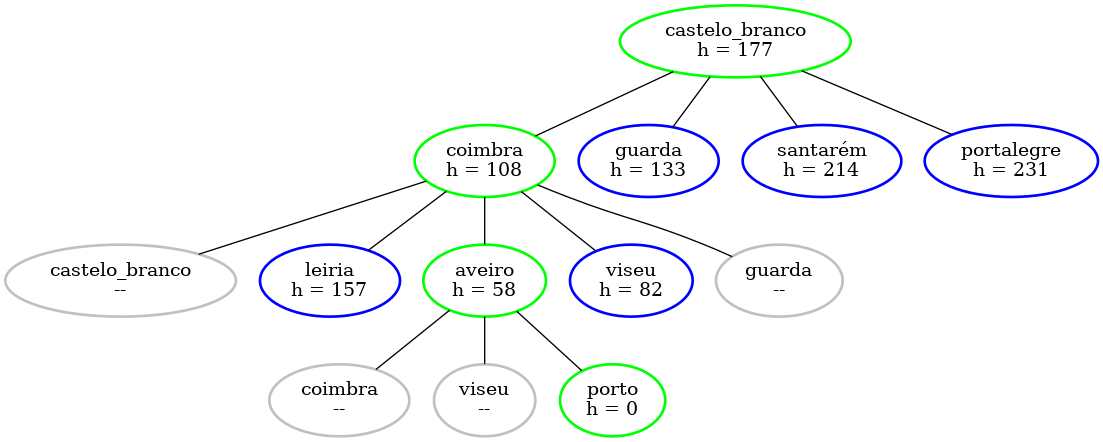

In [55]:
Image("src/q2_greedy.png")

#### Algoritmo A*

Tentativa com algoritmo A* para a solução problema do menor caminho entre as estradas de duas cidades, considerando a distância em linha reta dada *h(n)* + caminho percorrido *g(n)* como heurística 

```bash
FUNC greedy_algorithm(estado_inicial, estado_objetivo) -> solução
    visitados := [] # explorados
    g := {estado_inicial: 0} # g(n)
    fila_prioritaria := [(estado_inicial, h(estado_inicial))] # borda
    ENQUANTO fila_prioritaria tem elementos:
        estado_atual := fila_prioritaria.pop()
        SE estado_atual == estado_objetivo:
            RETORNA solução(estado_atual)

        visitados.add(estado_atual)
        PARA CADA vizinho, custo DE estado_atual:
            custo_caminho := g[estado_atual] + custo
            SE vizinho NÃO está em g OU custo_caminho < g[vizinho]:
                g[vizinho] = custo_caminho
                SE vizinho NÃO está em visitados:
                    fila_prioritaria.push((vizinho, h(vizinho) + g(vizinho)) # f(n) = h(n) + g(n)
```

In [80]:
def get_astar_path_and_graph(current, hash_current, hash_parent, parent, search_graph):
    path = []
    while current is not None:
        node = search_graph.get_node(hash_current)
        node.attr["color"] = "green"
        path.append(current)
        current = parent[current]
        hash_current = hash_parent[hash_current]
    path.reverse()
    return path, search_graph

In [112]:
def a_star(graph, start: str, end: str):
    visited = set()
    g = {start: 0}
    parent = {start : None}
    steps = 0

    search_graph = pgv.AGraph()
    search_graph.graph_attr['rankdir'] = 'BT'
    pgv_params = get_graphviz_node(start, h, g)
    search_graph.add_node(**pgv_params)
    hash_parent = {pgv_params.get("n") : None}

    queue = [(h[start] + g[start], start, pgv_params.get("n"))]
    
    while queue:
        _, current, hash_current = queue.pop(0)
        if current not in visited:
            steps += 1
            if current == end:
                print(f"No. steps: {steps}")
                return get_astar_path_and_graph(current, hash_current,
                                          hash_parent, parent, search_graph)
                
            visited.add(current)

            for v, w in graph.N(current):
                score = g[current] + w
                if v not in g or score < g[v]:
                    g[v] = score
                    parent[v] = current
                    
                    pgv_params = get_graphviz_node(v, h, g)
                    hash_v = pgv_params.get("n")
                    hash_parent[hash_v] = hash_current 
                    
                    if v not in visited:
                        heapq.heappush(queue, (h[v] + g[v], v,hash_v))

                
                    search_graph.add_node(**pgv_params)
                    search_graph.add_edge(hash_v, hash_parent[hash_v])

            heapq.heapify(queue)
            print(queue)
            

In [116]:
path, search_graph = a_star(graph, "castelo_branco", "porto")

search_graph.layout(prog='dot')
search_graph.draw('src/q2_astar.png')

[(233, 'guarda', '2179023ebbb47b41'), (268, 'coimbra', 'c754d87d3afc36a8'), (414, 'santarém', '8f73ee9d2b89bb4a'), (381, 'portalegre', 'd18305b150d076fe')]
[(262, 'viseu', '56be202e59ec2769'), (326, 'vila_real', '3e44f4c77c53516b'), (268, 'coimbra', 'c754d87d3afc36a8'), (472, 'bragança', 'a089cb91773ade40'), (414, 'santarém', '8f73ee9d2b89bb4a'), (381, 'portalegre', 'd18305b150d076fe')]
[(268, 'coimbra', 'c754d87d3afc36a8'), (326, 'vila_real', '3e44f4c77c53516b'), (338, 'aveiro', '625302efd56270d7'), (414, 'santarém', '8f73ee9d2b89bb4a'), (381, 'portalegre', 'd18305b150d076fe'), (472, 'bragança', 'a089cb91773ade40')]
[(298, 'aveiro', '46ef58424758c55a'), (338, 'aveiro', '625302efd56270d7'), (326, 'vila_real', '3e44f4c77c53516b'), (381, 'portalegre', 'd18305b150d076fe'), (472, 'bragança', 'a089cb91773ade40'), (414, 'santarém', '8f73ee9d2b89bb4a'), (387, 'leiria', '055844c066bd911c')]
[(310, 'porto', '06b127876b9261d7'), (326, 'vila_real', '3e44f4c77c53516b'), (338, 'aveiro', '625302efd5

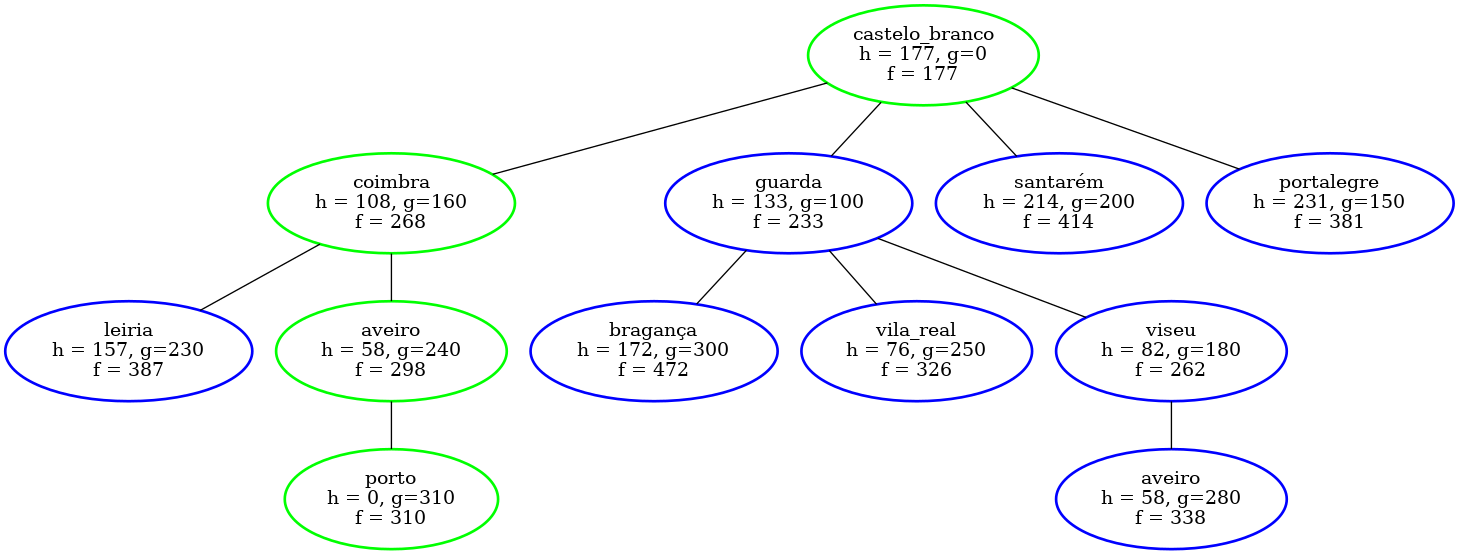

In [117]:
Image("src/q2_astar.png")